In [14]:
import os, sys
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

fwc = FlaresWithCOS(wavelength=np.append(w20, w30, axis=0), 
                    flux=np.append(f20, f30, axis=0),
                    flux_err=np.append(e20, e30, axis=0), 
                    time=np.append(t20, t30)-t20[0], 
                    orbit=np.append(o20, o30+5))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Checking count rates

In [4]:
path1 = '/Users/arcticfox/Documents/AUMic/30s/reduced/a'
path2 = '/Users/arcticfox/Documents/AUMic/30s/reduced2/a'

In [7]:
def get_counts(path):
    files = np.sort([os.path.join(path, i) for i in os.listdir(path) if
                 i.endswith('x1d.fits')])
    wave = []
    counts = []

    for i,fn in enumerate(files):
        hdu = fits.open(fn)
        wavelength = np.append(hdu[1].data['WAVELENGTH'][0], hdu[1].data['WAVELENGTH'][0])
        c = np.append(hdu[1].data['GCOUNTS'][0], hdu[1].data['GCOUNTS'][1])

        mask = np.where( ((wavelength >= 1173.65) & (wavelength <= 1198.49)) |
                         ((wavelength >= 1201.71) & (wavelength <= 1212.16)) |
                         ((wavelength >= 1219.18) & (wavelength <= 1274.04)) |
                         ((wavelength >= 1329.25) & (wavelength <= 1354.49)) |
                         ((wavelength >= 1356.71) & (wavelength <= 1357.59)) |
                         ((wavelength >= 1359.51) & (wavelength <= 1428.90)) )[0]

        wave.append(wavelength[mask])
        counts.append(c[mask])

        hdu.close()
    wave = np.array(wave)
    counts = np.array(counts)
    sum2 = np.zeros(len(files))
    for i in range(len(wave)):
        sum2[i] = np.nansum(counts[i])

    return wave, counts, sum2

In [8]:
w1, c1, s1 = get_counts(path1)
w2, c2, s2 = get_counts(path2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Text(0, 0.5, 'Sum of F130 Gross Counts')

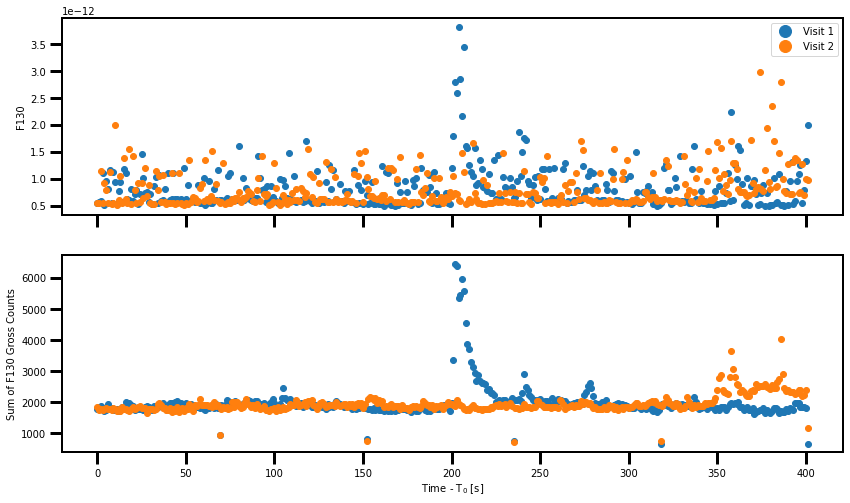

In [19]:
fwc.measure_FUV130()
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8), sharex=True)

ax1.plot(fwc.fuv130[fwc.orbit<5],'o',  label='Visit 1')
ax1.plot(fwc.fuv130[fwc.orbit>4],'o', label='Visit 2')
ax1.legend()
ax1.set_ylabel('F130')

ax2.plot(s1,'o', label='Visit 1')
ax2.plot( s2,'o',  label='Visit 2')
plt.xlabel('Time - T$_0$ [s]')
ax2.set_ylabel('Sum of F130 Gross Counts')
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/counts.png', rasterize=True,
#            dpi=300, bbox_inches='tight')#, transparent=True)